In [1]:
%matplotlib inline
from IPython.display import DisplayHandle, clear_output


def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)


DisplayHandle.update = update_patch
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np

from pcntoolkit.normative_model.norm_utils import norm_init
from pcntoolkit.util.utils import simulate_data

filterwarnings("ignore")

plt.rcParams.update({"font.size": 8, "figure.figsize": (5, 3)})


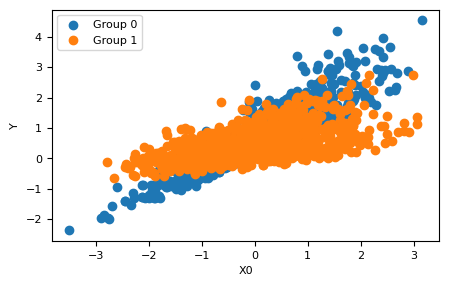

(2000,)


In [2]:
########################### Experiment Settings ###############################
random_state = 29
working_dir = (
    "/Users/stijndeboer/temp/"  # Specify a working directory to save data and results.
)
simulation_method = "linear"
n_features = 1  # The number of input features of X
n_grps = 2  # Number of batches in data
n_samples = 1000  # Number of samples in each group (use a list for different
# sample numbers across different batches)
model_type = "bspline"  # modelto try 'linear, ''polynomial', 'bspline'
############################## Data Simulation ################################
X_train, Y_train, grp_id_train, X_test, Y_test, grp_id_test, coef = simulate_data(
    simulation_method,
    n_samples,
    n_features,
    n_grps,
    working_dir=working_dir,
    plot=True,
    noise="heteroscedastic_nongaussian",
    random_state=random_state,
)
# plt.tight_layout()
# plt.show()
print(Y_train.shape)

# random_group_offsets = np.random.normal(0, 1, n_grps)
# print(random_group_offsets[grp_id_train])s
# Y_train += np.squeeze(np.array(random_group_offsets[grp_id_train]))
# Y_test += np.squeeze(np.array(random_group_offsets[grp_id_test]))

In [3]:
nm = norm_init(
    X_train,
    Y_train,
    alg="hbr",
    model_type=model_type,
    likelihood="Normal",
    random_intercept_mu="True",
    random_slope_mu="True",
    linear_sigma="True",
    linear_delta="False",
    linear_epsilon="False",
    nuts_sampler="nutpie",
)

In [4]:
# Graph is constructed here
nm.estimate(X_train, Y_train, trbefile=working_dir + "trbefile.pkl")

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1500,64,0.08,255


In [7]:
nm.hbr.pymc_model

AttributeError: 'HBR' object has no attribute 'pymc_model'

In [8]:
yhat, ys2 = nm.predict(X_test, tsbefile=working_dir + "tsbefile.pkl")

Sampling: [y_like]


(200, 7)


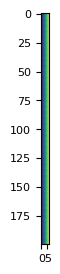

In [11]:
resolution = 200

z_scores = np.arange(-3, 4).astype(np.float32)
z_scores = np.tile(z_scores[None, :], (resolution, 1))

print(z_scores.shape)

a = np.tile(np.linspace(0, 0.2, 5)[:, None], (40, 7))
c = z_scores + a
plt.imshow(c)

Sampling: [y_like]


Sampling: [y_like]


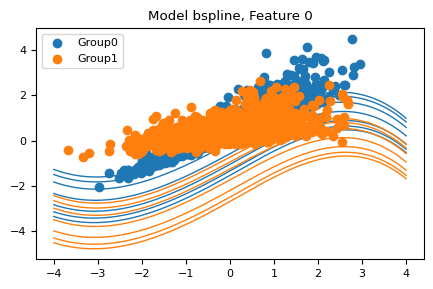

In [14]:
for i in range(n_features):
    sorted_idx = X_test[:, i].argsort(axis=0).squeeze()
    temp_X = X_test[sorted_idx, i]
    temp_Y = Y_test[sorted_idx,]
    temp_be = grp_id_test[sorted_idx, :].squeeze()
    temp_yhat = yhat[sorted_idx,]
    temp_s2 = ys2[sorted_idx,]

    plt.figure()
    for j in range(n_grps):
        scat1 = plt.scatter(
            temp_X[temp_be == j,], temp_Y[temp_be == j,], label="Group" + str(j)
        )
        # Showing the quantiles
        resolution = 200
        synth_X = np.linspace(-4, 4, resolution)
        q = nm.get_mcmc_quantiles(synth_X, batch_effects=j * np.ones(resolution))
        col = scat1.get_facecolors()[0]
        plt.plot(synth_X, q.T, linewidth=1, color=col, zorder=0)

    plt.title("Model %s, Feature %d" % (model_type, i))
    plt.legend()
    plt.show()